In [1]:
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import scipy

#READING IN DATA
file_path = "C:\\Users\VicariousL\Documents\part1_dataset1_1.dat"
data = np.loadtxt(file_path, dtype = float)

x_data = data[:, 0]
time_interval = x_data[1] - x_data[0]

y1_raw = data[:, 1]/time_interval
y1_data = np.log(y1_raw)
y1_error_raw = data[:, 2]/time_interval
y1_error = y1_error_raw/y1_raw

y2_raw = data[:, 3]/time_interval
y2_data = np.log(y2_raw)
y2_error_raw = data[:, 4]/time_interval
y2_error = y2_error_raw/y2_raw

y3_raw = data[:, 5]/time_interval
y3_data = np.log(y3_raw)
y3_error_raw = data[:, 6]/time_interval
y3_error = y3_error_raw/y3_raw

y4_raw = data[:, 7]/time_interval
y4_data = np.log(y4_raw)
y4_error_raw = data[:, 8]/time_interval
y4_error = y4_error_raw/y4_raw

In [2]:
#CONSTANTS
#All quantities are in standard units
cross_sec = 3.124/10000
percent_unc_cs = (0.001/3.124)*100
dist = [0.05, 0.1, 0.18, 0.3]
dist_error = np.ones(4) * 0.0005
ln_dist = np.log(dist)
e_ln_dist = dist_error/dist

#Isotope Half Lives
Cs_120 = 61.2
Cs_121 = 154.8
Cs_124 = 30.9
Ba_123 = 162
Ba_124 = 660
Ba_125 = 210
Ba_137 = 153.1
Eu_137 = 8.4
Eu_138 = 12.1
Eu_139 = 17.9
Eu_143 = 155.4
W_166 = 19.2
W_168 = 51
W_169 = 76.2
Np_229 = 240
Np_230 = 276
Np_232 = 882

In [3]:
#FUNCTIONS

#Input data, gradient and intercept to return linear fit
def linear(x, m, c):
    return m*x + c

#Input data, initial activity and decay constant to return exponential fit
def exp1(x, A1, lambda1):
    return A1*np.exp(-lambda1*x)

#Input x, y data and errors to return sums used in least squares fit
def chi_sums(x_data, y_data, error):
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    error = np.array(error)
    
    inv_y_error2 = 1/(error*error)
    S = np.sum(inv_y_error2)
    x = x_data * inv_y_error2
    y = y_data * inv_y_error2
    xy = x_data * y_data * inv_y_error2
    xx = x_data * x_data * inv_y_error2
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(xy)
    sum_xx = np.sum(xx)
    
    return S, sum_x, sum_y, sum_xx, sum_xy

#Function to input sums from chi_sums to return gradient for least squares fit
def grad(S, sum_x, sum_y, sum_xx, sum_xy):
    gradient = (S*sum_xy - sum_x*sum_y)/(S*sum_xx - sum_x*sum_x)
    return gradient

#Function to input sums from chi_sums to return intercept for least squares fit
def intercept(S, sum_x, sum_y, sum_xx, sum_xy):
    intercept = (sum_xx*sum_y - sum_x*sum_xy)/(S*sum_xx - sum_x*sum_x)
    return intercept

#Function to input data, fit and errors to return chi squared value
def chi2(data, fit, error):
    x = ((data-fit)**2)/error**2
    chi = np.sum(x)
    return chi

#Function to input x data, y data, errors, an initial fit, residual and interations to bootstrap gradients and intercepts
#Mean + standard deviations and Median + 16 - 84% CI of gradients and intercepts are returned
def bootstrap(x_data, y_data, error, initial_fit, initial_resids, iterations):
    
    m_new_list = []
    c_new_list = []
    
    for i in np.arange(1, iterations, 1):
        indices = random.sample(range(0, len(x_data)), k = len(x_data)) #Random numbers selected from list of consecutive numbers ranging from 0 to len(x_data)
        res_sample = [initial_resids[a] for a in indices] #Residuals selected from initial residual list at indices within the indices list
        error = [error[a] for a in indices] #Corresponding errors at same indices selected and held in list
        
        new_fit = initial_fit + res_sample #New fit generated from initial fit + new residuals
        
        S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, new_fit, error) #New chi sums calculated
        
        m_new = grad(S, sum_x, sum_y, sum_xx, sum_xy) #Corresponding gradient and intercepts calculated
        c_new = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
        
        m_new_list.append(m_new) #Gradients and Intercepts appended to lists
        c_new_list.append(c_new)
    
    #Various statistics calculated from gradient and intercept lists
    mean_m = statistics.mean(m_new_list)
    median_m = statistics.median(m_new_list)
    std_m = statistics.stdev(m_new_list)

    mean_c = statistics.mean(c_new_list)
    median_c = statistics.median(c_new_list)
    std_c = statistics.stdev(c_new_list)
    
    return mean_m, median_m, std_m, mean_c, median_c, std_c, m_new_list, c_new_list

In [4]:
#FUNCTIONS - DATASET PROCESSING - Previous functions are combined with commands to return salient data and help reduce redundancy

#Function to perform chi squared fit on dataset with errors and return gradient, intercept, residuals and chi squared value
#Inputs are the x and y data with errors
def perform_chi_square_fit(x_data, y_data, error):
    S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, y_data, error)
    m = grad(S, sum_x, sum_y, sum_xx, sum_xy)
    c = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
    fit = linear(x_data, m, c)
    residuals = fit - y_data
    return m, c, fit, residuals

#Function to use gradient and intercept parameters from linear Ln Activity vs Ln Time fit and provide an exponential fit with corresponding chi squared value
#y_data is Ln activity used for the linear fit, raw_data is the original data for which the exponential fit is determined
def process_exp_dataset(x_data, y_data, error, raw_data, raw_error):
    m, c, fit = perform_chi_square_fit(x_data, y_data, error)[:3]
    exp_fit = exp1(x_data, np.exp(c), -m)
    exp_res = exp_fit - raw_data
    chi_squared = chi2(raw_data, exp_fit, raw_error)
    return exp_fit, exp_res, chi_squared

#Function to prepare data for plotting a histogram of bootstrapped gradients and intercepts
#Data for a cumulative chart with 16 - 84% CIs is also prepared
def process_bootstrap_histogram(boot_mlist, boot_clist, bins=30):
    values_m, base_m = np.histogram(boot_mlist, bins=bins)
    cumulative_m = np.cumsum(values_m)
    values_c, base_c = np.histogram(boot_clist, bins=bins)
    cumulative_c = np.cumsum(values_c)
    
    x_percentile_16_m = np.percentile(base_m[:-1], 16)
    x_percentile_84_m = np.percentile(base_m[:-1], 84)
    x_percentile_16_c = np.percentile(base_c[:-1], 16)
    x_percentile_84_c = np.percentile(base_c[:-1], 84)
    
    confidence_interval_m = (x_percentile_16_m, x_percentile_84_m)
    confidence_interval_c = (x_percentile_16_c, x_percentile_84_c)
    
    med_unc_m = np.ones(2) * np.median(boot_mlist) - confidence_interval_m
    med_unc_c = np.ones(2) * np.median(boot_clist) - confidence_interval_c
    
    return values_m, base_m, cumulative_m, values_c, base_c, cumulative_c, confidence_interval_m, confidence_interval_c, med_unc_m, med_unc_c

#Function to calculated half lives from decay constants with uncertainties propagated
#Half lives can be calculated from both mean and median decay constants 
def calculate_half_life(mean_m, std_m, med_m, med_unc_m):
    t_half = np.log(2) / -mean_m
    t_unc = (np.log(2) / mean_m**2) * std_m
    t_half_med = np.log(2) / -med_m
    t_med_unc = (np.log(2) / med_m**2) * med_unc_m
    return t_half, t_unc, t_half_med, t_med_unc

#Function to calculate the number of particles in the isotope from activity at the detector
#Percentage uncertainties in the cross section, decay constant and activity are used to determine error in particle number
def calculate_number(dist, cross_sec, mean_m, std_m, mean_c, std_c, percent_unc_cs):
    sa = 4 * np.pi * dist ** 2
    area_ratio = sa / cross_sec
    N = (np.exp(mean_c) / -mean_m) * area_ratio
    percent_unc_m = (std_m / -mean_m) * 100
    percent_unc_c = (np.exp(mean_c) * std_c / np.exp(mean_c)) * 100
    total_percent_unc = percent_unc_m + percent_unc_c + percent_unc_cs
    N_unc = (N / 100) * total_percent_unc
    return N, N_unc, percent_unc_m, percent_unc_c, total_percent_unc

#Function to implement scipy to perform data fit for comparison
def scipy_chi2(x_data, y_data, raw_data, raw_error):
    parameters, covariance = scipy.optimize.curve_fit(linear, x_data, y_data)
    m_opt, c_opt = parameters
    exp_fit_scipy = exp1(x_data, np.exp(c_opt), -m_opt)
    chi2_scipy = chi2(raw_data, exp_fit_scipy, raw_error)
    return m_opt, c_opt, exp_fit_scipy, chi2_scipy

In [5]:
#IMPLEMENTING FUNCTIONS FOR DATASETS
# Dataset 1
#Initial fit parameters and residuals determined from least squares fit
m1, c1, fit1, res1 = perform_chi_square_fit(x_data, y1_data, y1_error)

#Fit parameters used for exponential fit
exp_fit1, exp_res1, chi2_1 = process_exp_dataset(x_data, y1_data, y1_error, y1_raw, y1_error_raw)

#Fit parameters are bootstrapped to determine best fit parameters and uncertainties
boot1 = bootstrap(x_data, y1_data, y1_error, fit1, res1, 1000)
mean_m1, med_m1, std_m1, mean_c1, med_c1, std_c1, boot_mlist1, boot_clist1 = boot1

#Information for bootstrapped parameter histograms calculated
values_m1, base_m1, cumulative_m1, values_c1, base_c1, cumulative_c1, confidence_interval_m1, confidence_interval_c1, med_unc_m1, med_unc_c1 = process_bootstrap_histogram(boot_mlist1, boot_clist1)

#Isotope half life calculcated with uncertainties
t_half1, t_unc1, t_half_med1, t_med_unc1 = calculate_half_life(mean_m1, std_m1, med_m1, med_unc_m1)

#Number of particles with uncertainties calculated
N1, N1_unc, percent_unc_m1, percent_unc_c1, total_percent_unc1 = calculate_number(dist[0], cross_sec, mean_m1, std_m1, mean_c1, std_c1, percent_unc_cs)

#Scipy fit paramters calculated
m_opt1, c_opt1, exp_fit_scipy1, chi2_scipy_1 = scipy_chi2(x_data, y1_data, y1_raw, y1_error_raw)

#Same procedure repeated for other datasets
# Dataset 2
m2, c2, fit2, res2 = perform_chi_square_fit(x_data, y2_data, y2_error)
exp_fit2, exp_res2, chi2_2 = process_exp_dataset(x_data, y2_data, y2_error, y2_raw, y2_error_raw)
boot2 = bootstrap(x_data, y2_data, y2_error, fit2, res2, 1000)
mean_m2, med_m2, std_m2, mean_c2, med_c2, std_c2, boot_mlist2, boot_clist2 = boot2
values_m2, base_m2, cumulative_m2, values_c2, base_c2, cumulative_c2, confidence_interval_m2, confidence_interval_c2, med_unc_m2, med_unc_c2 = process_bootstrap_histogram(boot_mlist2, boot_clist2)
t_half2, t_unc2, t_half_med2, t_med_unc2 = calculate_half_life(mean_m2, std_m2, med_m2, med_unc_m2)
N2, N2_unc, percent_unc_m2, percent_unc_c2, total_percent_unc2 = calculate_number(dist[1], cross_sec, mean_m2, std_m2, mean_c2, std_c2, percent_unc_cs)
m_opt2, c_opt2, exp_fit_scipy2, chi2_scipy_2 = scipy_chi2(x_data, y2_data, y2_raw, y2_error_raw)

# Dataset 3
m3, c3, fit3, res3 = perform_chi_square_fit(x_data, y3_data, y3_error)
exp_fit3, exp_res3, chi2_3 = process_exp_dataset(x_data, y3_data, y3_error, y3_raw, y3_error_raw)
boot3 = bootstrap(x_data, y3_data, y3_error, fit3, res3, 1000)
mean_m3, med_m3, std_m3, mean_c3, med_c3, std_c3, boot_mlist3, boot_clist3 = boot3
values_m3, base_m3, cumulative_m3, values_c3, base_c3, cumulative_c3, confidence_interval_m3, confidence_interval_c3, med_unc_m3, med_unc_c3 = process_bootstrap_histogram(boot_mlist3, boot_clist3)
t_half3, t_unc3, t_half_med3, t_med_unc3 = calculate_half_life(mean_m3, std_m3, med_m3, med_unc_m3)
N3, N3_unc, percent_unc_m3, percent_unc_c3, total_percent_unc3 = calculate_number(dist[2], cross_sec, mean_m3, std_m3, mean_c3, std_c3, percent_unc_cs)
m_opt3, c_opt3, exp_fit_scipy3, chi2_scipy_3 = scipy_chi2(x_data, y3_data, y3_raw, y3_error_raw)

# Dataset 4
m4, c4, fit4, res4 = perform_chi_square_fit(x_data, y4_data, y4_error)
exp_fit4, exp_res4, chi2_4 = process_exp_dataset(x_data, y4_data, y4_error, y4_raw, y4_error_raw)
boot4 = bootstrap(x_data, y4_data, y4_error, fit4, res4, 1000)
mean_m4, med_m4, std_m4, mean_c4, med_c4, std_c4, boot_mlist4, boot_clist4 = boot4
values_m4, base_m4, cumulative_m4, values_c4, base_c4, cumulative_c4, confidence_interval_m4, confidence_interval_c4, med_unc_m4, med_unc_c4 = process_bootstrap_histogram(boot_mlist4, boot_clist4)
t_half4, t_unc4, t_half_med4, t_med_unc4 = calculate_half_life(mean_m4, std_m4, med_m4, med_unc_m4)
N4, N4_unc, percent_unc_m4, percent_unc_c4, total_percent_unc4 = calculate_number(dist[3], cross_sec, mean_m4, std_m4, mean_c4, std_c4, percent_unc_cs)
m_opt4, c_opt4, exp_fit_scipy4, chi2_scipy_4 = scipy_chi2(x_data, y4_data, y4_raw, y4_error_raw)

Power relation between Activity and Distance = -2.047698324826608 ± 0.030100045826671275


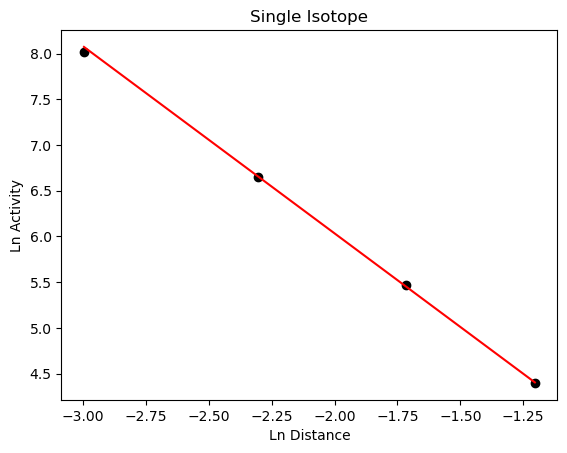

In [6]:
#ACTIVITY AS A FUNCTION OF DISTANCE
#distances with errors are defined in the constants section
points = np.linspace(1, len(boot_mlist1), len(boot_mlist1)) #This is used elsewhere for plotting bootstrapped parameter plots
A_list = np.array([c1, c2, c3, c4]) #Array of initial activities

S_d, sum_x_d, sum_y_d, sum_xx_d, sum_xy_d = chi_sums(ln_dist, A_list, e_ln_dist) #gradient and intercept for chi squared fit are calculated
m_d = grad(S_d, sum_x_d, sum_y_d, sum_xx_d, sum_xy_d) 
c_d = intercept(S_d, sum_x_d, sum_y_d, sum_xx_d, sum_xy_d)

fit_d = m_d*ln_dist + c_d
res_d = A_list - fit_d

boot_d = bootstrap(ln_dist, A_list, e_ln_dist, fit_d, res_d, 1000) #gradient is bootstrapped
std_m_d = boot_d[2]

plt.figure(0)
plt.scatter(ln_dist, A_list, color = 'black')
plt.errorbar(ln_dist, A_list, e_ln_dist, linestyle = '', color = 'black')
plt.plot(ln_dist, fit_d, color = 'red')
plt.xlabel('Ln Distance')
plt.ylabel('Ln Activity')
plt.title('Single Isotope')

print('Power relation between Activity and Distance = ' + str(m_d) + ' ' + u"\u00B1" + ' ' + str(std_m_d))

In [7]:
#PRINT STATEMENTS - DECAY CONSTANTS, INITIAL ACTIVITIES
print('DECAY CONSTANTS AND INITIAL ACTIVITIES')
print('Dataset 1: Decay Constant (Mean and St Dev) = ' + str(np.abs(mean_m1)) + ' ' + u"\u00B1" + ' ' + str(std_m1))
print('Dataset 1: Decay Constant (Median and 16-84% CI) = ' + str(np.abs(med_m1)) + ' ' + u"\u00B1" + ' ' + str(np.abs(med_unc_m1)))
print('Dataset 1: Initial Activity (Mean and St Dev) = ' + str(np.exp(mean_c1)) + ' ' + u"\u00B1" + ' ' + str(np.exp(mean_c1)*std_c1))
print('Dataset 1: Initial Activity (Median and 16-84% CI) = ' + str(np.exp(med_c1)) + ' ' + u"\u00B1" + ' ' + str(np.abs(np.exp(med_c1)*med_unc_c1)))
print('Dataset 1: Chi Squared = ' + str(chi2_1))
print('Dataset 1: Scipy Decay Constant  = ' + str(np.abs(m_opt1)))
print('Dataset 1: Scipy Initial Activity  = ' + str(np.exp(c_opt1)))
print('Dataset 1: Chi Squared Scipy Parameters  = ' + str(chi2_scipy_1))
print("\n")
print('Dataset 2: Decay Constant (Mean and St Dev) = ' + str(np.abs(mean_m2)) + ' ' + u"\u00B1" + ' ' + str(std_m2))
print('Dataset 2: Decay Constant (Median and 16-84% CI) = ' + str(np.abs(med_m2)) + ' ' + u"\u00B1" + ' ' + str(np.abs(med_unc_m2)))
print('Dataset 2: Initial Activity (Mean and St Dev) = ' + str(np.exp(mean_c2)) + ' ' + u"\u00B1" + ' ' + str(np.exp(mean_c2)*std_c2))
print('Dataset 2: Initial Activity (Median and 16-84% CI) = ' + str(np.exp(med_c2)) + ' ' + u"\u00B1" + ' ' + str(np.abs(np.exp(med_c2)*med_unc_c2)))
print('Dataset 2: Chi Squared = ' + str(chi2_2))
print('Dataset 2: Scipy Decay Constant  = ' + str(np.abs(m_opt2)))
print('Dataset 2: Scipy Initial Activity  = ' + str(np.exp(c_opt2)))
print('Dataset 2: Chi Squared Scipy Parameters  = ' + str(chi2_scipy_2))
print("\n")
print('Dataset 3: Decay Constant (Mean and St Dev) = ' + str(np.abs(mean_m3)) + ' ' + u"\u00B1" + ' ' + str(std_m3))
print('Dataset 3: Decay Constant (Median and 16-84% CI) = ' + str(np.abs(med_m3)) + ' ' + u"\u00B1" + ' ' + str(med_unc_m3))
print('Dataset 3: Initial Activity (Mean and St Dev) = ' + str(np.exp(mean_c3)) + ' ' + u"\u00B1" + ' ' + str(np.exp(mean_c3)*std_c3))
print('Dataset 3: Initial Activity (Median and 16-84% CI) = ' + str(np.exp(med_c3)) + ' ' + u"\u00B1" + ' ' + str(np.abs(np.exp(med_c3)*med_unc_c3)))
print('Dataset 3: Chi Squared = ' + str(chi2_3))
print('Dataset 3: Scipy Decay Constant  = ' + str(np.abs(m_opt3)))
print('Dataset 3: Scipy Initial Activity  = ' + str(np.exp(c_opt3)))
print('Dataset 3: Chi Squared Scipy Parameters  = ' + str(chi2_scipy_3))
print("\n")
print('Dataset 4: Decay Constant (Mean and St Dev) = ' + str(np.abs(m4)) + ' ' + u"\u00B1" + ' ' + str(std_m4))
print('Dataset 4: Decay Constant (Median and 16-84% CI) = ' + str(np.abs(med_m4)) + ' ' + u"\u00B1" + ' ' + str(np.abs(med_unc_m4)))
print('Dataset 4: Initial Activity (Mean and St Dev) = ' + str(np.exp(mean_c4)) + ' ' + u"\u00B1" + ' ' + str(np.exp(mean_c4)*std_c4))
print('Dataset 4: Initial Activity (Median and 16-84% CI) = ' + str(np.exp(med_c4)) + ' ' + u"\u00B1" + ' ' + str(np.abs(np.exp(med_c4)*med_unc_c4)))
print('Dataset 4: Chi Squared = ' + str(chi2_4))
print('Dataset 4: Scipy Decay Constant  = ' + str(np.abs(m_opt4)))
print('Dataset 4: Scipy Initial Activity  = ' + str(np.exp(c_opt4)))
print('Dataset 4: Chi Squared Scipy Parameters  = ' + str(chi2_scipy_4))
print("\n")

DECAY CONSTANTS AND INITIAL ACTIVITIES
Dataset 1: Decay Constant (Mean and St Dev) = 0.057569333328948404 ± 0.0006541726264892982
Dataset 1: Decay Constant (Median and 16-84% CI) = 0.057543027638519394 ± [0.0014417 0.0017097]
Dataset 1: Initial Activity (Mean and St Dev) = 3077.739723908182 ± 85.59259450777053
Dataset 1: Initial Activity (Median and 16-84% CI) = 3074.3171279168205 ± [241.1111066  179.04710697]
Dataset 1: Chi Squared = 100.88791203014584
Dataset 1: Scipy Decay Constant  = 0.05823232561361036
Dataset 1: Scipy Initial Activity  = 3085.1182057557953
Dataset 1: Chi Squared Scipy Parameters  = 104.06273947955658


Dataset 2: Decay Constant (Mean and St Dev) = 0.05825325842394139 ± 0.0014367099241949757
Dataset 2: Decay Constant (Median and 16-84% CI) = 0.05822661065728302 ± [0.00338206 0.00403321]
Dataset 2: Initial Activity (Mean and St Dev) = 796.0329311720734 ± 49.78315832304432
Dataset 2: Initial Activity (Median and 16-84% CI) = 793.2833512302526 ± [102.78448895 131.696

In [8]:
#PRINT STATEMENTS - POWER LAW RELATION AND HALF LIVES
print('POWER LAW RELATION AND HALF LIVES')
print('Power relation between Activity and Distance = ' + str(m_d) + ' ' + u"\u00B1" + ' ' + str(std_m_d))
print("\n")
print('Dataset 1: Half Life (Mean & St Dev) = ' + str(t_half1) + ' ' + u"\u00B1" + ' ' + str(t_unc1) + 's')
print('Dataset 1: Half Life (Median & CI) = ' + str(t_half_med1) + ' ' + u"\u00B1" + ' ' + str(np.abs(t_med_unc1)))
print("\n")
print('Dataset 2: Half Life (Mean & St Dev) = ' + str(t_half2) + ' ' + u"\u00B1" + ' ' + str(t_unc2) + 's')
print('Dataset 2: Half Life (Median & CI) = ' + str(t_half_med2) + ' ' + u"\u00B1" + ' ' + str(np.abs(t_med_unc2)))
print("\n")
print('Dataset 3: Half Life (Mean & St Dev) = ' + str(t_half3) + ' ' + u"\u00B1" + ' ' + str(t_unc3) + 's')
print('Dataset 3: Half Life (Median & CI) = ' + str(t_half_med3) + ' ' + u"\u00B1" + ' ' + str(np.abs(t_med_unc3)))
print("\n")
print('Dataset 4: Half Life (Mean & St Dev) = ' + str(t_half4) + ' ' + u"\u00B1" + ' ' + str(t_unc4) + 's')
print('Dataset 4: Half Life (Median & CI) = ' + str(t_half_med4) + ' ' + u"\u00B1" + ' ' + str(np.abs(t_med_unc4)))
print("\n")

POWER LAW RELATION AND HALF LIVES
Power relation between Activity and Distance = -2.047698324826608 ± 0.030100045826671275


Dataset 1: Half Life (Mean & St Dev) = 12.040215518900238 ± 0.1368155396987303s
Dataset 1: Half Life (Median & CI) = 12.045719681526654 ± [0.30179715 0.35789945]


Dataset 2: Half Life (Mean & St Dev) = 11.898856807554479 ± 0.29346350958734596s
Dataset 2: Half Life (Median & CI) = 11.904302392590767 ± [0.69145386 0.82458005]


Dataset 3: Half Life (Mean & St Dev) = 12.380017588335756 ± 1.002057901889065s
Dataset 3: Half Life (Median & CI) = 12.384548702839552 ± [2.23168788 2.56977594]


Dataset 4: Half Life (Mean & St Dev) = 13.269162945171143 ± 1.354082565027384s
Dataset 4: Half Life (Median & CI) = 13.296833557803742 ± [3.27860358 3.117896  ]




In [9]:
#IDENTIFYING ISOTOPE FROM CALCULATED HALF LIFE
half_life_listnames = np.array(['Cesium_120', 'Cesium_121', 'Cesium_124', 'Barium_123', 'Barium_124', 'Barium_125', 'Barium_137', 'Europium_137', 'Europium_138', 'Europium_139', 'Europium_143', 'Tungsten_166', 'Tungsten_168', 'Tungsten_169', 'Neptunium_229', 'Neptunium_230', 'Neptunium_232'])
half_life_list = np.array([Cs_120, Cs_121, Cs_124, Ba_123, Ba_124, Ba_125, Ba_137, Eu_137, Eu_138, Eu_139, Eu_143, W_166, W_168, W_169, Np_229, Np_230, Np_232])

dataset_half_life = t_half1 #change to t_half2, 3 or 4 to identify isotopes from half lives of other datasets

diff_list = []

for i in half_life_list:
    half_life_diff = np.abs(dataset_half_life - i)
    diff_list.append(half_life_diff)

isotope_index = diff_list.index(min(diff_list))
isotope_half_life = half_life_list[isotope_index]
isotope_identity = half_life_listnames[isotope_index]

print('Isotope present in sample = ' + ' ' + isotope_identity)
print('Isotope half life = ' + ' ' + str(isotope_half_life))

Isotope present in sample =  Europium_138
Isotope half life =  12.1


In [10]:
#PRINT STATEMENTS - NUMBER OF PARTICLES
print('NUMBER OF PARTICLES')
print('Dataset 1: Number of particles in isotope = ' + str(N1) + ' ' + u"\u00B1" + ' ' + str(N1_unc))
print('Dataset 2: Number of particles in isotope = ' + str(N2) + ' ' + u"\u00B1" + ' ' + str(N2_unc))
print('Dataset 3: Number of particles in isotope = ' + str(N3) + ' ' + u"\u00B1" + ' ' + str(N3_unc))
print('Dataset 4: Number of particles in isotope = ' + str(N4) + ' ' + u"\u00B1" + ' ' + str(N4_unc))

NUMBER OF PARTICLES
Dataset 1: Number of particles in isotope = 5376251.010802864 ± 212327.12007821843
Dataset 2: Number of particles in isotope = 5496796.391798094 ± 481092.4813753875
Dataset 3: Number of particles in isotope = 6844997.518148062 ± 1934379.010382738
Dataset 4: Number of particles in isotope = 7594361.027475544 ± 2565975.3012301573


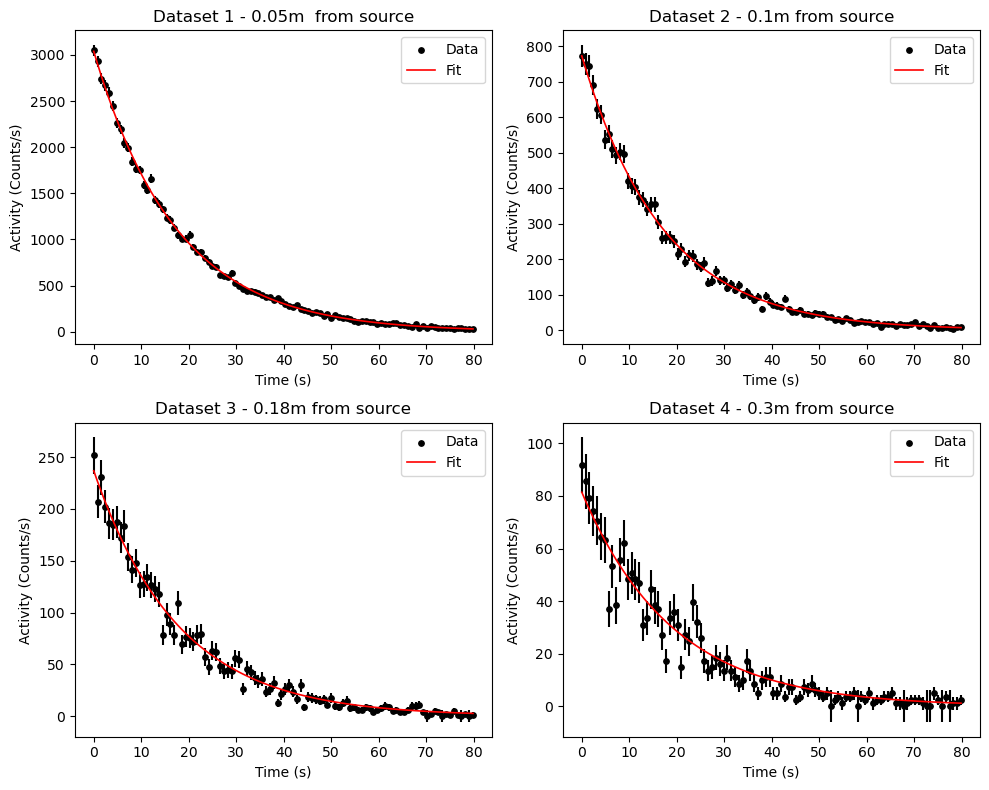

In [11]:
#PLOTS - EXPONENTIAL FITS TO DATA
#Plot for Dataset 1
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

axs[0, 0].scatter(x_data, y1_raw, s=15, color='black', label='Data')
axs[0, 0].errorbar(x_data, y1_raw, y1_error_raw, linestyle='', color='black')
axs[0, 0].plot(x_data, exp_fit1, color='red', linewidth=1.2, label='Fit')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Activity (Counts/s)')
axs[0, 0].set_title('Dataset 1 - 0.05m  from source')
axs[0, 0].legend(loc='upper right')

# Plot for Dataset 2
axs[0, 1].scatter(x_data, y2_raw, s=15, color='black', label='Data')
axs[0, 1].errorbar(x_data, y2_raw, y2_error_raw, linestyle='', color='black')
axs[0, 1].plot(x_data, exp_fit2, color='red', linewidth=1.2, label='Fit')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Activity (Counts/s)')
axs[0, 1].set_title('Dataset 2 - 0.1m from source')
axs[0, 1].legend(loc='upper right')

# Plot for Dataset 3
axs[1, 0].scatter(x_data, y3_raw, s=15, color='black', label='Data')
axs[1, 0].errorbar(x_data, y3_raw, y3_error_raw, linestyle='', color='black')
axs[1, 0].plot(x_data, exp_fit3, color='red', linewidth=1.2, label='Fit')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Activity (Counts/s)')
axs[1, 0].set_title('Dataset 3 - 0.18m from source')
axs[1, 0].legend(loc='upper right')

# Plot for Dataset 4
axs[1, 1].scatter(x_data, y4_raw, s=15, color='black', label='Data')
axs[1, 1].errorbar(x_data, y4_raw, y4_error_raw, linestyle='', color='black')
axs[1, 1].plot(x_data, exp_fit4, color='red', linewidth=1.2, label='Fit')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Activity (Counts/s)')
axs[1, 1].set_title('Dataset 4 - 0.3m from source')
axs[1, 1].legend(loc='upper right')


plt.tight_layout()

<Figure size 640x480 with 0 Axes>

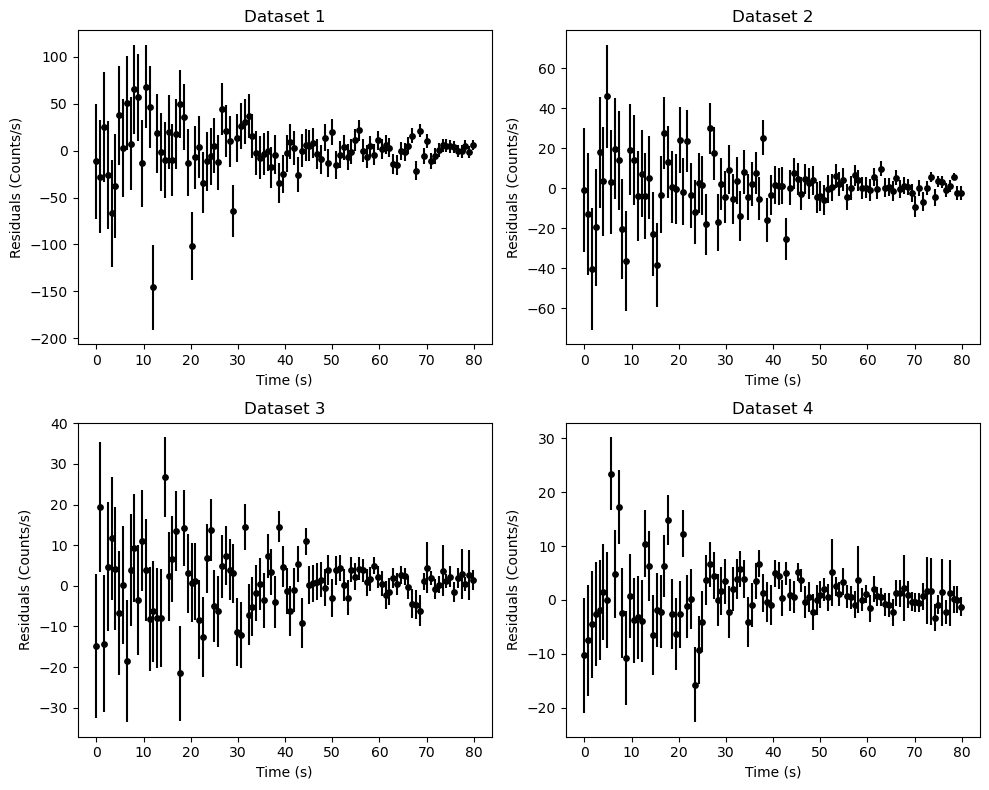

In [12]:
#PLOTS - RESIDUALS
plt.figure(5)
fig1, axs1 = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

#Plot for Dataset 1
axs1[0, 0].scatter(x_data, exp_res1, s=15, color='black', label='Data')
axs1[0, 0].errorbar(x_data, exp_res1, y1_error_raw, linestyle='', color='black')
axs1[0, 0].set_xlabel('Time (s)')
axs1[0, 0].set_ylabel('Residuals (Counts/s)')
axs1[0, 0].set_title('Dataset 1')

# Plot for Dataset 2
axs1[0, 1].scatter(x_data, exp_res2, s=15, color='black', label='Data')
axs1[0, 1].errorbar(x_data, exp_res2, y2_error_raw, linestyle='', color='black')
axs1[0, 1].set_xlabel('Time (s)')
axs1[0, 1].set_ylabel('Residuals (Counts/s)')
axs1[0, 1].set_title('Dataset 2')

# Plot for Dataset 3
axs1[1, 0].scatter(x_data, exp_res3, s=15, color='black', label='Data')
axs1[1, 0].errorbar(x_data, exp_res3, y3_error_raw, linestyle='', color='black')
axs1[1, 0].set_xlabel('Time (s)')
axs1[1, 0].set_ylabel('Residuals (Counts/s)')
axs1[1, 0].set_title('Dataset 3')

# Plot for Dataset 4
axs1[1, 1].scatter(x_data, exp_res4, s=15, color='black', label='Data')
axs1[1, 1].errorbar(x_data, exp_res4, y4_error_raw, linestyle='', color='black')
axs1[1, 1].set_xlabel('Time (s)')
axs1[1, 1].set_ylabel('Residuals (Counts/s)')
axs1[1, 1].set_title('Dataset 4')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

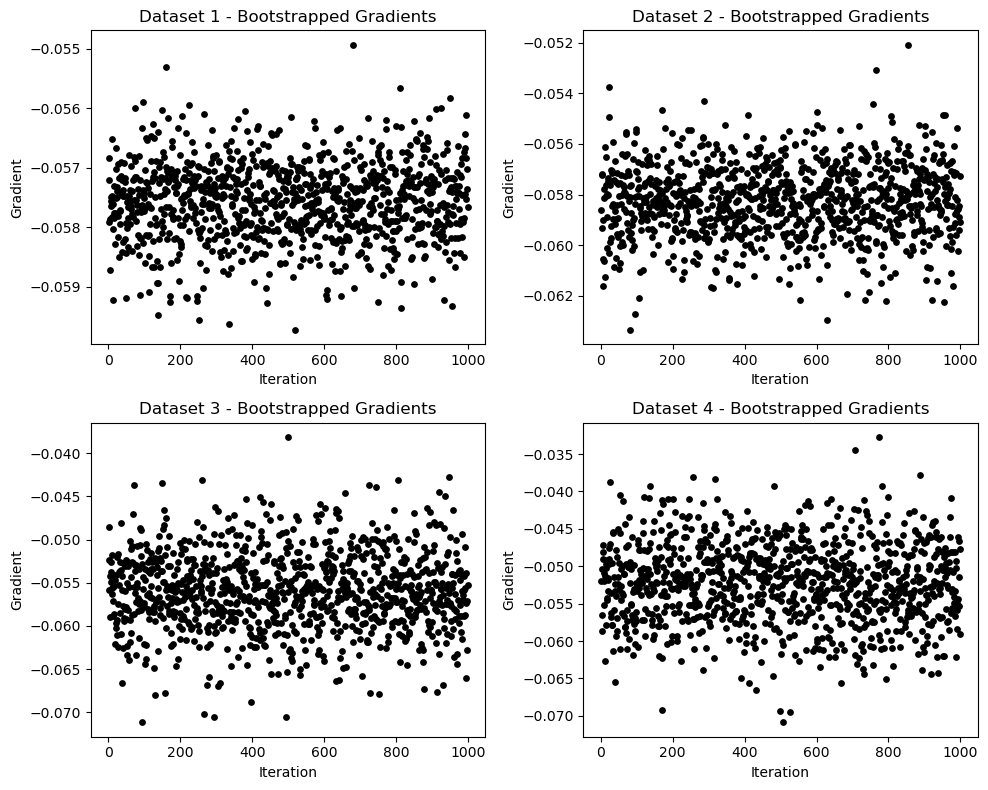

In [13]:
#PLOTS - BOOTSTRAPPED GRADIENTS
plt.figure(0)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

#Plot for Dataset 1
axs[0, 0].scatter(points, boot_mlist1, s=15, color='black', label='Data')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Gradient')
axs[0, 0].set_title('Dataset 1 - Bootstrapped Gradients')

# Plot for Dataset 2
axs[0, 1].scatter(points, boot_mlist2, s=15, color='black', label='Data')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Gradient')
axs[0, 1].set_title('Dataset 2 - Bootstrapped Gradients')

# Plot for Dataset 3
axs[1, 0].scatter(points, boot_mlist3, s=15, color='black', label='Data')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Gradient')
axs[1, 0].set_title('Dataset 3 - Bootstrapped Gradients')

# Plot for Dataset 4
axs[1, 1].scatter(points, boot_mlist4, s=15, color='black', label='Data')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Gradient')
axs[1, 1].set_title('Dataset 4 - Bootstrapped Gradients')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

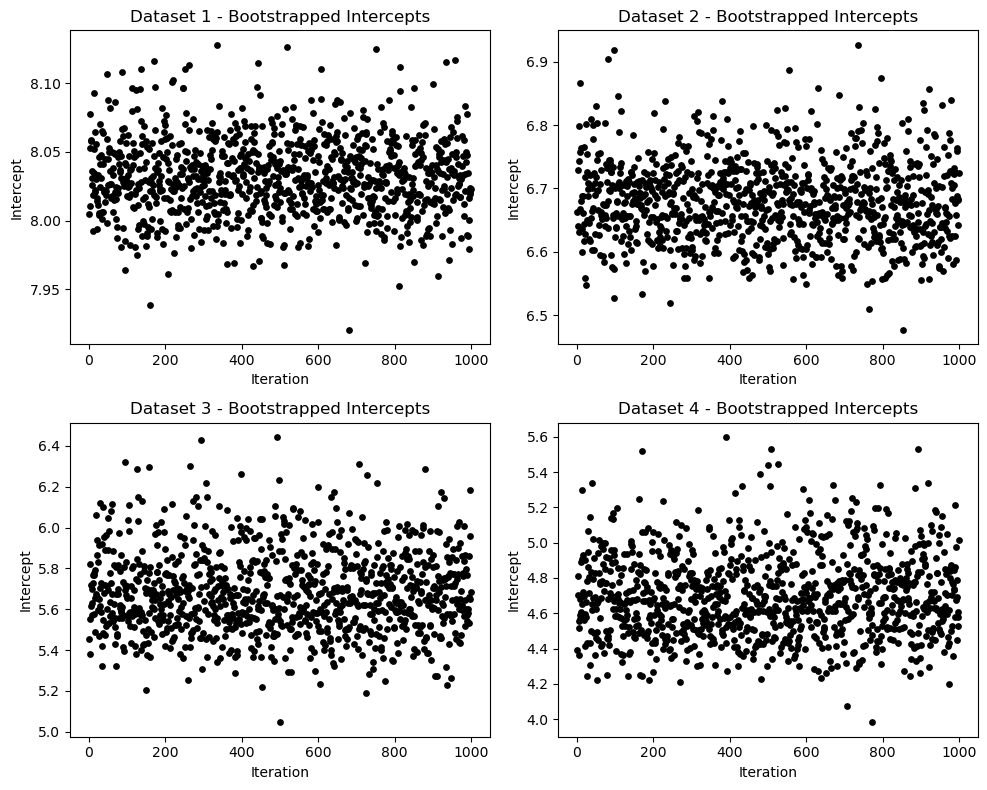

In [14]:
#PLOTS - BOOTSTRAPPED INTERCEPTS
plt.figure(1)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

#Plot for Dataset 1
axs[0, 0].scatter(points, boot_clist1, s=15, color='black', label='Data')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Intercept')
axs[0, 0].set_title('Dataset 1 - Bootstrapped Intercepts')

# Plot for Dataset 2
axs[0, 1].scatter(points, boot_clist2, s=15, color='black', label='Data')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Intercept')
axs[0, 1].set_title('Dataset 2 - Bootstrapped Intercepts')

# Plot for Dataset 3
axs[1, 0].scatter(points, boot_clist3, s=15, color='black', label='Data')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Intercept')
axs[1, 0].set_title('Dataset 3 - Bootstrapped Intercepts')

# Plot for Dataset 4
axs[1, 1].scatter(points, boot_clist4, s=15, color='black', label='Data')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Intercept')
axs[1, 1].set_title('Dataset 4 - Bootstrapped Intercepts')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

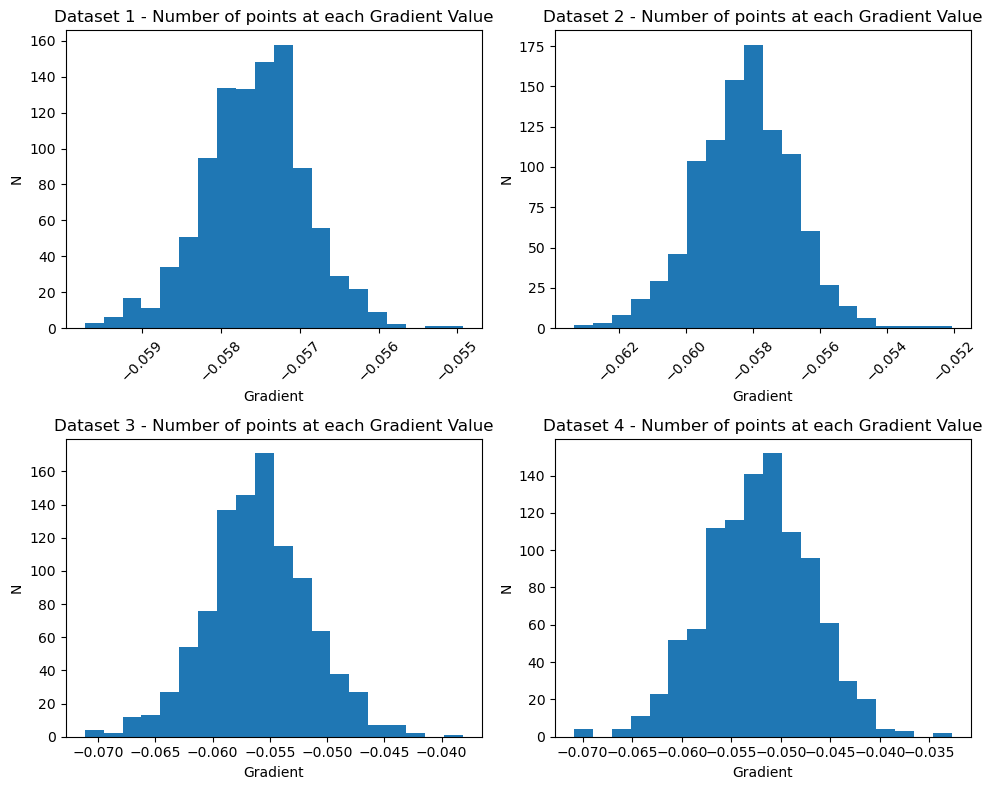

In [15]:
#PLOTS - BOOTSTRAPPED GRADIENT HISTOGRAMS
plt.figure(2)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

#Plot for Dataset 1
axs[0, 0].hist(boot_mlist1, bins = 20)
axs[0, 0].set_xlabel('Gradient')
axs[0, 0].set_ylabel('N')
axs[0, 0].set_title('Dataset 1 - Number of points at each Gradient Value')
axs[0, 0].tick_params(axis='x', rotation=45)  

# Plot for Dataset 2
axs[0, 1].hist(boot_mlist2, bins = 20)
axs[0, 1].set_xlabel('Gradient')
axs[0, 1].set_ylabel('N')
axs[0, 1].set_title('Dataset 2 - Number of points at each Gradient Value')
axs[0, 1].tick_params(axis='x', rotation=45)  

# Plot for Dataset 3
axs[1, 0].hist(boot_mlist3, bins = 20)
axs[1, 0].set_xlabel('Gradient')
axs[1, 0].set_ylabel('N')
axs[1, 0].set_title('Dataset 3 - Number of points at each Gradient Value')

# Plot for Dataset 4
axs[1, 1].hist(boot_mlist4, bins = 20)
axs[1, 1].set_xlabel('Gradient')
axs[1, 1].set_ylabel('N')
axs[1, 1].set_title('Dataset 4 - Number of points at each Gradient Value')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

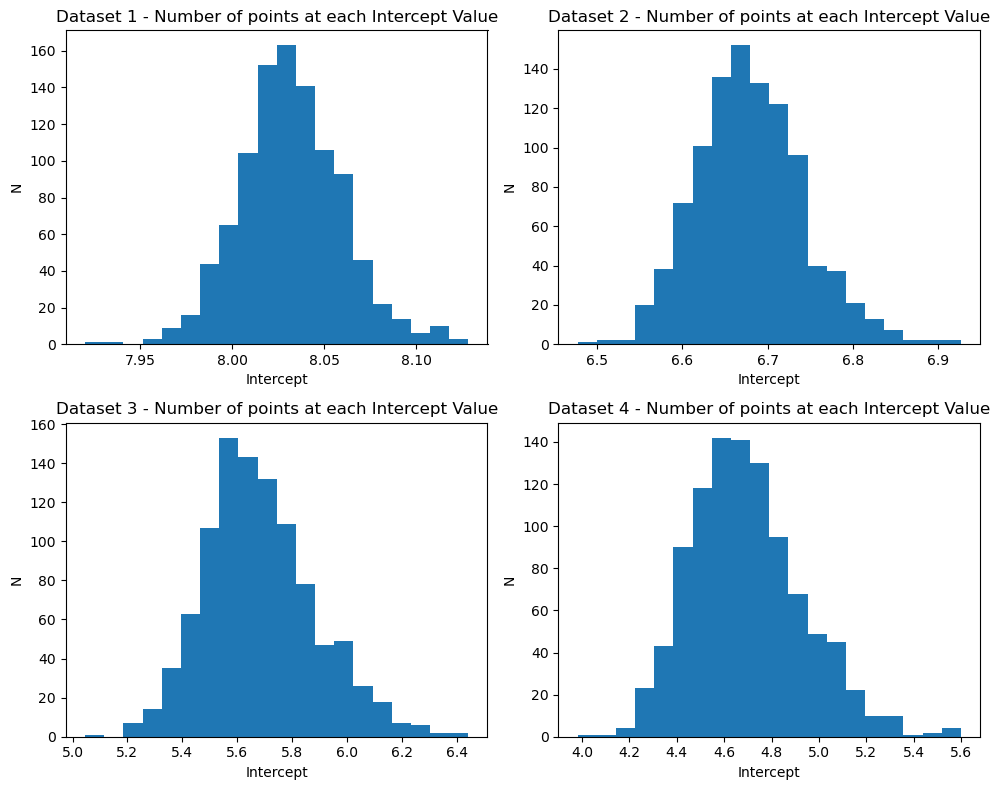

In [16]:
#PLOTS - BOOTSTRAPPED INTERCEPT HISTOGRAMS
plt.figure(3)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

#Plot for Dataset 1
axs[0, 0].hist(boot_clist1, bins = 20)
axs[0, 0].set_xlabel('Intercept')
axs[0, 0].set_ylabel('N')
axs[0, 0].set_title('Dataset 1 - Number of points at each Intercept Value')

# Plot for Dataset 2
axs[0, 1].hist(boot_clist2, bins = 20)
axs[0, 1].set_xlabel('Intercept')
axs[0, 1].set_ylabel('N')
axs[0, 1].set_title('Dataset 2 - Number of points at each Intercept Value')

# Plot for Dataset 3
axs[1, 0].hist(boot_clist3, bins = 20)
axs[1, 0].set_xlabel('Intercept')
axs[1, 0].set_ylabel('N')
axs[1, 0].set_title('Dataset 3 - Number of points at each Intercept Value')

# Plot for Dataset 4
axs[1, 1].hist(boot_clist4, bins = 20)
axs[1, 1].set_xlabel('Intercept')
axs[1, 1].set_ylabel('N')
axs[1, 1].set_title('Dataset 4 - Number of points at each Intercept Value')

plt.tight_layout()